In [2]:
### Cell 1: Initial Imports ###

# Standard libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Resampling libraries from imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Scikit-learn for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, PrecisionRecallDisplay

# Import all the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb # State-of-the-art model

# Set display options
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [3]:
### Cell 2: Load Data ###

# Load the original dataset
try:
    data = pd.read_csv('creditcard.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {data.shape}")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please ensure the file is in the correct directory.")
    data = None

Dataset loaded successfully.
Dataset shape: (284807, 31)


In [4]:
### Cell 3: Feature Selection and Data Preparation ###

if data is not None:
    # Based on your report, we will use the ANOVA-selected feature set as it yielded better results.
    # This set excludes features with an ANOVA score less than 50.
    feature_cols = [
        'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V27'
    ]
    
    # Ensure all selected feature columns exist in the dataframe
    existing_feature_cols = [col for col in feature_cols if col in data.columns]
    
    X = data[existing_feature_cols]
    y = data['Class']

    print("Features and target variable defined using the ANOVA-selected set.")
    print("Original class distribution:")
    print(y.value_counts())

Features and target variable defined using the ANOVA-selected set.
Original class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
### Cell 4: Train-Test Split on ORIGINAL Data ###

if data is not None:
    # Split the original, imbalanced data first.
    x_train, x_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y  # 'stratify' ensures the split respects the original class proportions
    )
    print("Original data split into training (80%) and testing (20%) sets.")

Original data split into training (80%) and testing (20%) sets.


In [6]:
### Cell 5: Hybrid Resampling of the Training Set ###

if data is not None:
    # Define the resampling strategies
    over = SMOTE(sampling_strategy=0.5, random_state=42)
    under = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
    
    # Create the imblearn pipeline
    pipeline = Pipeline(steps=[('under', under), ('over', over)])
    
    # Apply the pipeline ONLY to the training data
    x_train_resampled, y_train_resampled = pipeline.fit_resample(x_train, y_train)

    print("Training data has been resampled.")
    print("New class distribution in the resampled training data:")
    print(Counter(y_train_resampled))

Training data has been resampled.
New class distribution in the resampled training data:
Counter({0: 3940, 1: 1970})


In [11]:
### Cell 6 (Updated): Computationally-Heavy Hyperparameter Tuning for Random Forest ###

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print("--- Starting Computationally-Heavy Hyperparameter Tuning for Random Forest ---")

# Define a much larger and more detailed parameter grid to search
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12, None],  # 'None' allows trees to grow to their maximum depth
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'], # The number of features to consider when looking for the best split
    'class_weight': ['balanced']
}

# Increase the cross-validation folds to 5 for a more robust evaluation
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_weighted', # Optimizing for a weighted F1-score is excellent for imbalance
    cv=5,
    n_jobs=-1, # Use all available CPU cores
    verbose=2
)

# Fit the grid search on the resampled training data
grid_search_rf.fit(x_train_resampled, y_train_resampled)

# Get the best model from the more exhaustive search
best_rf_tuned = grid_search_rf.best_estimator_
print(f"\nBest parameters found for Random Forest: {grid_search_rf.best_params_}")

# Evaluate the NEW, more thoroughly tuned model on the original test set
print("\n--- Classification Report for Exhaustively Tuned Random Forest ---")
tuned_rf_predictions = best_rf_tuned.predict(x_test)
print(classification_report(y_test, tuned_rf_predictions))

--- Starting Computationally-Heavy Hyperparameter Tuning for Random Forest ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters found for Random Forest: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

--- Classification Report for Exhaustively Tuned Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.30      0.90      0.45        98

    accuracy                           1.00     56962
   macro avg       0.65      0.95      0.72     56962
weighted avg       1.00      1.00      1.00     56962



In [12]:
### Cell 7 (Updated): Hyperparameter Tuning for XGBoost ###

import xgboost as xgb

print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

# Define a parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# The scale_pos_weight is a fixed, good practice for imbalance, so we set it directly in the estimator
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

# Increase CV folds and use f1_weighted scoring for consistency
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=scale_pos_weight_value,
        use_label_encoder=False,
        random_state=42
    ),
    param_grid=param_grid_xgb,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on the resampled training data
grid_search_xgb.fit(x_train_resampled, y_train_resampled)

# Get the best model from the search
best_xgb_tuned = grid_search_xgb.best_estimator_
print(f"\nBest parameters found for XGBoost: {grid_search_xgb.best_params_}")

# Evaluate the NEW, TUNED XGBoost model on the original test set
print("\n--- Classification Report for Tuned XGBoost ---")
tuned_xgb_predictions = best_xgb_tuned.predict(x_test)
print(classification_report(y_test, tuned_xgb_predictions))


--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\aarya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:38:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

--- Classification Report for Tuned XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.91      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962




--- Feature Importance from Tuned Random Forest ---


C:\Users\aarya\AppData\Local\Temp\ipykernel_34716\2466397081.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


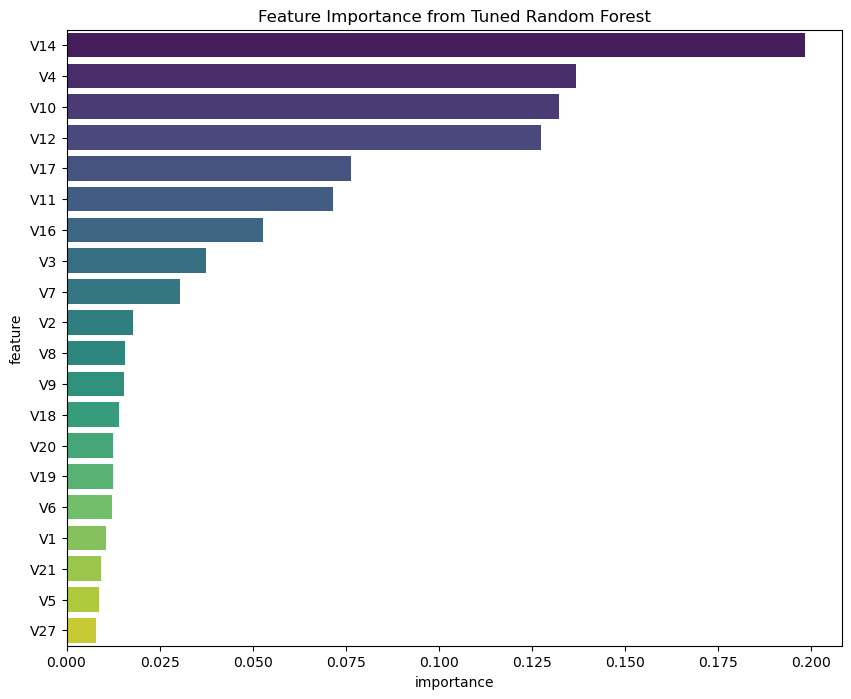

In [13]:
### Cell 8: Deeper Analysis - Feature Importance ###

if data is not None:
    print("\n--- Feature Importance from Tuned Random Forest ---")
    
    importances = best_rf_tuned.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': existing_feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importance from Tuned Random Forest')
    plt.show()


--- Plotting Precision-Recall Curves ---


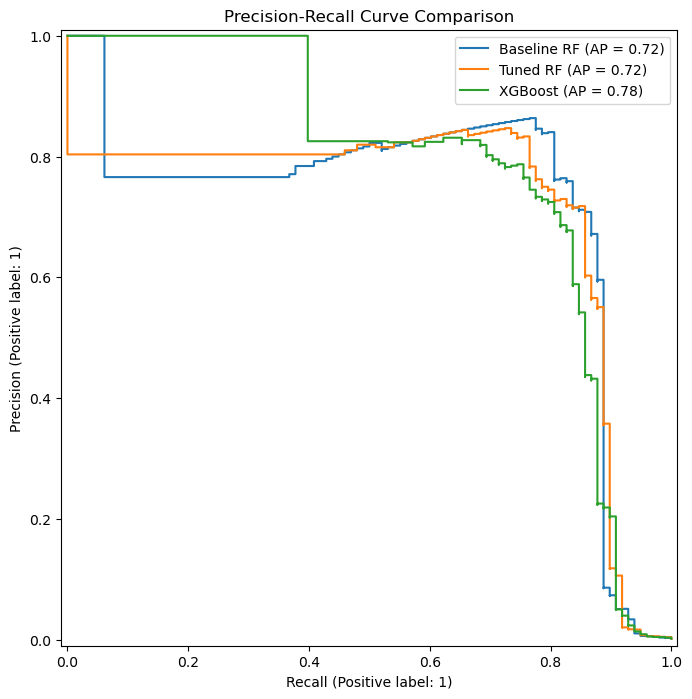

In [14]:
### Cell 9: Deeper Analysis - Precision-Recall Curve Comparison ###

if data is not None:
    print("\n--- Plotting Precision-Recall Curves ---")
    
    # Re-train the baseline RF on resampled data for a fair comparison plot
    baseline_rf = RandomForestClassifier(max_depth=4, random_state=0)
    baseline_rf.fit(x_train_resampled, y_train_resampled)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot for the original Random Forest
    PrecisionRecallDisplay.from_estimator(baseline_rf, x_test, y_test, name="Baseline RF", ax=ax)
    
    # Plot for the new Tuned Random Forest
    PrecisionRecallDisplay.from_estimator(best_rf_tuned, x_test, y_test, name="Tuned RF", ax=ax)

    # Plot for XGBoost
    PrecisionRecallDisplay.from_estimator(classifier_xgb, x_test, y_test, name="XGBoost", ax=ax)

    plt.title("Precision-Recall Curve Comparison")
    plt.legend()
    plt.show()

C:\Users\aarya\AppData\Local\Temp\ipykernel_34716\2287972375.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis') # Show top 10


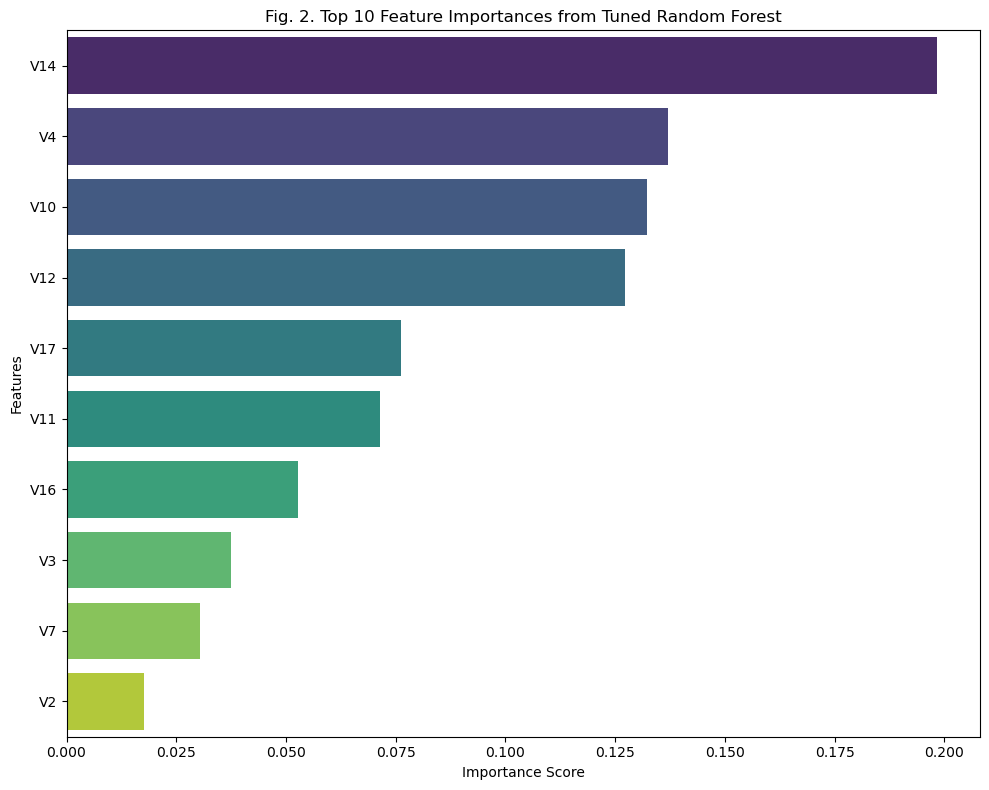

In [18]:
# CODE TO GENERATE FEATURE IMPORTANCE PLOT
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'best_rf_tuned' is your best Random Forest model from GridSearchCV
# and 'existing_feature_cols' is the list of your ANOVA-selected feature names

importances = best_rf_tuned.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': existing_feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis') # Show top 10
plt.title('Fig. 2. Top 10 Feature Importances from Tuned Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [19]:
# CODE TO GENERATE HYPERPARAMETER TUNING RESULTS TABLE
import pandas as pd

# Ensure 'grid_search_rf' and 'grid_search_xgb' are your fitted GridSearchCV objects

# Data for the table
tuning_results = {
    'Model': ['Tuned Random Forest', 'Tuned XGBoost'],
    'Best Parameters': [
        str(grid_search_rf.best_params_),
        str(grid_search_xgb.best_params_)
    ],
    'Best F1-Score (on CV)': [
        f"{grid_search_rf.best_score_:.4f}",
        f"{grid_search_xgb.best_score_:.4f}"
    ]
}

# Create a pandas DataFrame
results_df = pd.DataFrame(tuning_results)

# Display the table in a format you can copy to your paper
print("TABLE I. HYPERPARAMETER TUNING RESULTS")
print(results_df.to_markdown(index=False))

TABLE I. HYPERPARAMETER TUNING RESULTS
| Model               | Best Parameters                                                                                                                             |   Best F1-Score (on CV) |
|:--------------------|:--------------------------------------------------------------------------------------------------------------------------------------------|------------------------:|
| Tuned Random Forest | {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300} |                  0.9832 |
| Tuned XGBoost       | {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}                                      |                  0.9875 |


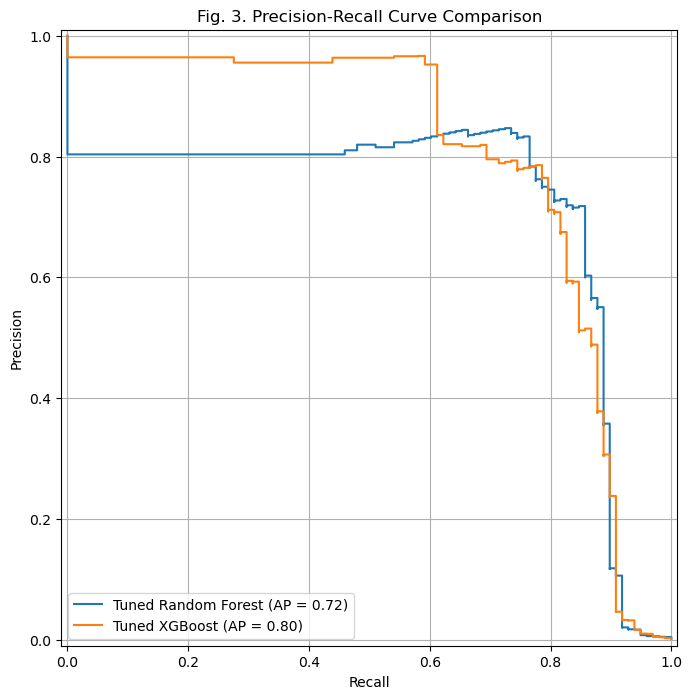

In [20]:
# CODE TO GENERATE PRECISION-RECALL CURVE COMPARISON
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Ensure you have your best fitted models: 'best_rf_tuned' and 'best_xgb_tuned'

fig, ax = plt.subplots(figsize=(10, 8))

# Plot for the Tuned Random Forest
PrecisionRecallDisplay.from_estimator(best_rf_tuned, x_test, y_test, name="Tuned Random Forest", ax=ax)

# Plot for the Tuned XGBoost
PrecisionRecallDisplay.from_estimator(best_xgb_tuned, x_test, y_test, name="Tuned XGBoost", ax=ax)

plt.title('Fig. 3. Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Ensure you have your fitted models ('best_rf_tuned', 'best_xgb_tuned') and your test data ('x_test', 'y_test')

# Get predictions
rf_preds = best_rf_tuned.predict(x_test)
xgb_preds = best_xgb_tuned.predict(x_test)

# Calculate scores
performance_data = {
    'Model': ['Tuned Random Forest', 'Tuned XGBoost'],
    'Precision (Fraud)': [
        precision_score(y_test, rf_preds, pos_label=1),
        precision_score(y_test, xgb_preds, pos_label=1)
    ],
    'Recall (Fraud)': [
        recall_score(y_test, rf_preds, pos_label=1),
        recall_score(y_test, xgb_preds, pos_label=1)
    ],
    'F1-Score (Fraud)': [
        f1_score(y_test, rf_preds, pos_label=1),
        f1_score(y_test, xgb_preds, pos_label=1)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, best_rf_tuned.predict_proba(x_test)[:, 1]),
        roc_auc_score(y_test, best_xgb_tuned.predict_proba(x_test)[:, 1])
    ]
}

# Create and format the DataFrame
performance_df = pd.DataFrame(performance_data)
performance_df[['Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUC-ROC']] = performance_df[['Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUC-ROC']].applymap('{:.4f}'.format)


# Display the table in a format you can copy to your paper
print("TABLE II. FINAL MODEL PERFORMANCE COMPARISON")
print(performance_df.to_markdown(index=False))

TABLE II. FINAL MODEL PERFORMANCE COMPARISON
| Model               |   Precision (Fraud) |   Recall (Fraud) |   F1-Score (Fraud) |   AUC-ROC |
|:--------------------|--------------------:|-----------------:|-------------------:|----------:|
| Tuned Random Forest |              0.2983 |           0.898  |             0.4478 |    0.9811 |
| Tuned XGBoost       |              0.1017 |           0.9082 |             0.1829 |    0.9791 |


C:\Users\aarya\AppData\Local\Temp\ipykernel_34716\261934896.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  performance_df[['Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUC-ROC']] = performance_df[['Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUC-ROC']].applymap('{:.4f}'.format)
